In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model

np.random.seed(123)
tf.random.set_seed(123)

In [61]:
!pip install -U scikit-learn

In [62]:
from sklearn.metrics import mean_absolute_percentage_error

In [63]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [64]:
df['LogPassengers'] = np.log(df['Passengers'])

In [65]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [66]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [67]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

In [68]:
# Make supervised dataset
series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (133, 10, 1) Y.shape (133,)


In [69]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [70]:
# CNN
i = Input(shape=(T, 1))
x = Conv1D(16, 3, activation='relu')(i)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1)(x)
model = Model(i, x)

In [71]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [72]:
r = model.fit(
  Xtrain,
  Ytrain,
  epochs=100,
  validation_data=(Xtest, Ytest)
)

Epoch 1/100
4/4 [==============================] - 1s 55ms/step - loss: 0.0125 - val_loss: 0.0111
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0112 - val_loss: 0.0108
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0111 - val_loss: 0.0108
Epoch 4/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0109 - val_loss: 0.0105
Epoch 5/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0105 - val_loss: 0.0101
Epoch 6/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0103 - val_loss: 0.0099
Epoch 7/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 8/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0097 - val_loss: 0.0095
Epoch 9/100
4/4 [==============================] - 0s 40ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 10/100
4/4 [==============================] - 0s 22ms/step - loss: 0.0092 - val_loss: 0.0091
Epoch 11/100
4/4 [=

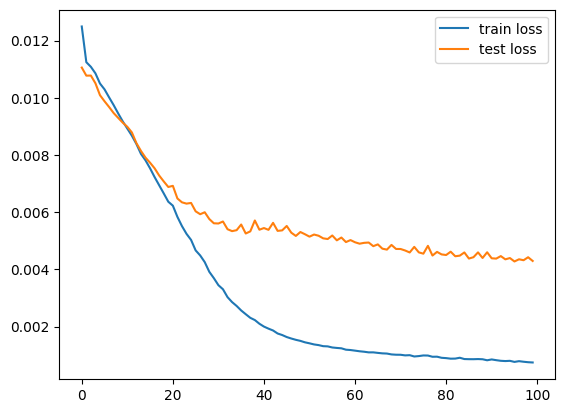

In [73]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [74]:
train_idx[:T+1] = False

In [75]:
Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()

1/1 [==============================] - 0s 37ms/step


In [76]:
# Store diff predictions
df.loc[train_idx, 'Diff Train Prediction'] = Ptrain
df.loc[test_idx, 'Diff Test Prediction'] = Ptest

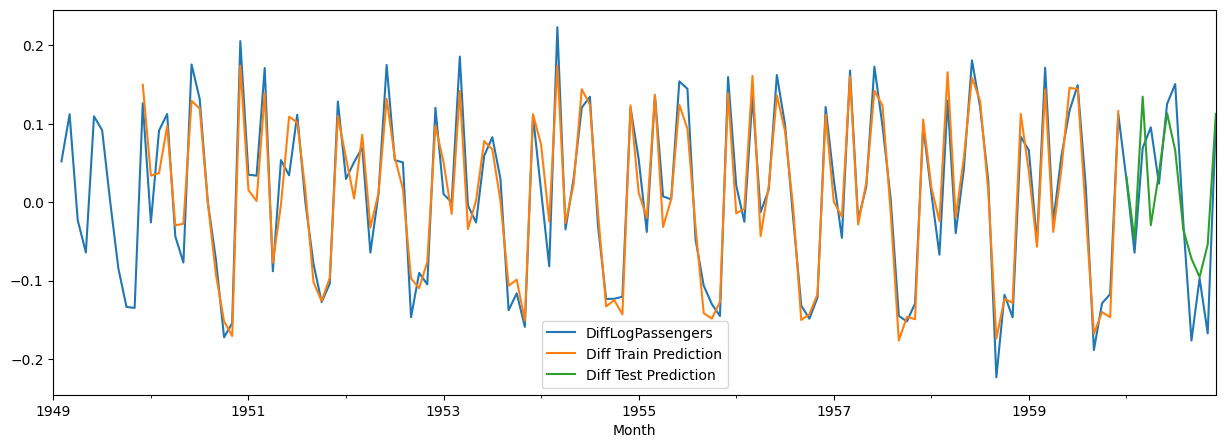

In [77]:
cols = ['DiffLogPassengers',
        'Diff Train Prediction',
        'Diff Test Prediction']
df[cols].plot(figsize=(15, 5));

In [78]:
# Needed to compute un-differenced predictions
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [79]:
# Last-known train value
last_train = train.iloc[-1]['LogPassengers']

In [80]:
# 1-step forecast
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

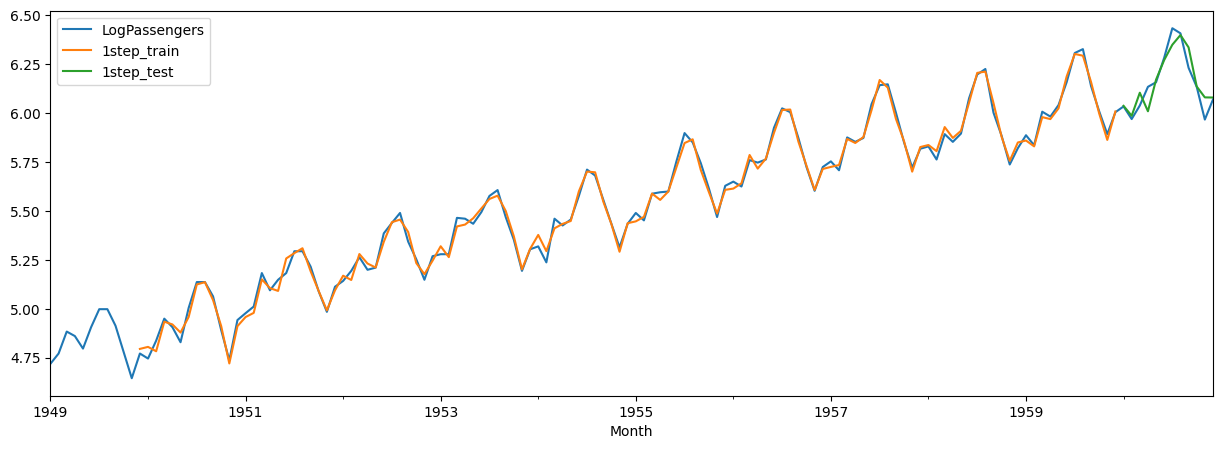

In [81]:
# plot 1-step forecast
df[['LogPassengers', '1step_train', '1step_test']].plot(figsize=(15, 5));

In [82]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = model.predict(last_x.reshape(1, -1, 1))[0]

  # update the predictions list
  multistep_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

1/1 [==============================] - 0s 20ms/step


In [83]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

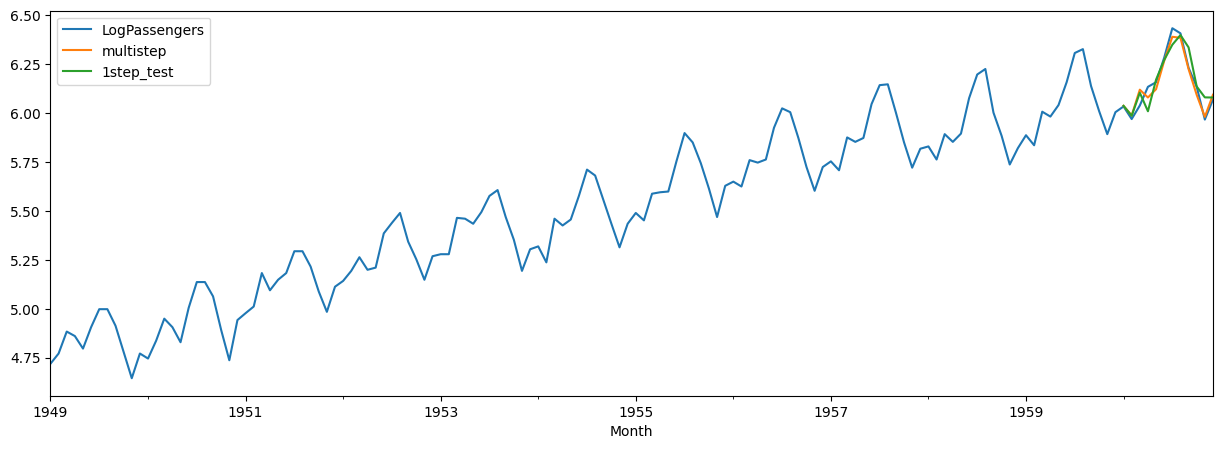

In [84]:
# plot 1-step and multi-step forecast
df[['LogPassengers', 'multistep', '1step_test']].plot(figsize=(15, 5));

In [85]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx, 1)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (122, 10, 1) Y.shape (122, 12)


In [86]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [87]:
# CNN
i = Input(shape=(Tx, 1))
x = Conv1D(16, 3, activation='relu')(i)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)
model = Model(i, x)

In [88]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [89]:
r = model.fit(
  Xtrain_m,
  Ytrain_m,
  epochs=200,
  validation_data=(Xtest_m, Ytest_m)
)

Epoch 1/200
4/4 [==============================] - 1s 62ms/step - loss: 0.0122 - val_loss: 0.0125
Epoch 2/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0114 - val_loss: 0.0122
Epoch 3/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0111 - val_loss: 0.0118
Epoch 4/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0109 - val_loss: 0.0114
Epoch 5/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0107 - val_loss: 0.0108
Epoch 6/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0106 - val_loss: 0.0103
Epoch 7/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0104 - val_loss: 0.0100
Epoch 8/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0102 - val_loss: 0.0095
Epoch 9/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0101 - val_loss: 0.0092
Epoch 10/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0099 - val_loss: 0.0089
Epoch 11/200
4/4 [=

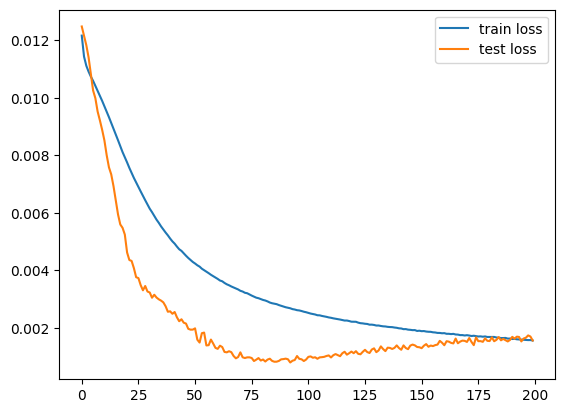

In [90]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [91]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

1/1 [==============================] - 0s 48ms/step


In [92]:
Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

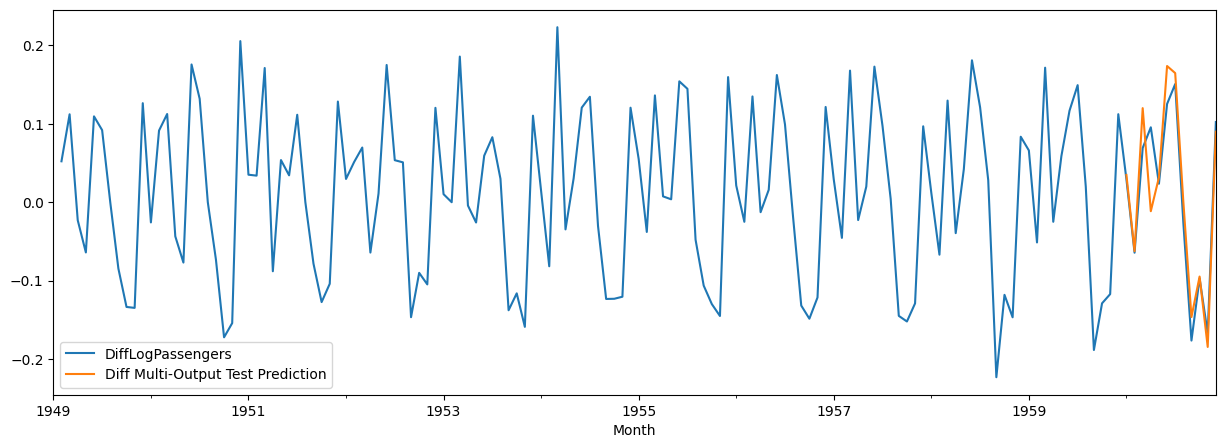

In [93]:
df.loc[test_idx, 'Diff Multi-Output Test Prediction'] = Ptest
cols = ['DiffLogPassengers', 'Diff Multi-Output Test Prediction']
df[cols].plot(figsize=(15, 5));

In [94]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput'] = last_train + \
  np.cumsum(Ptest)

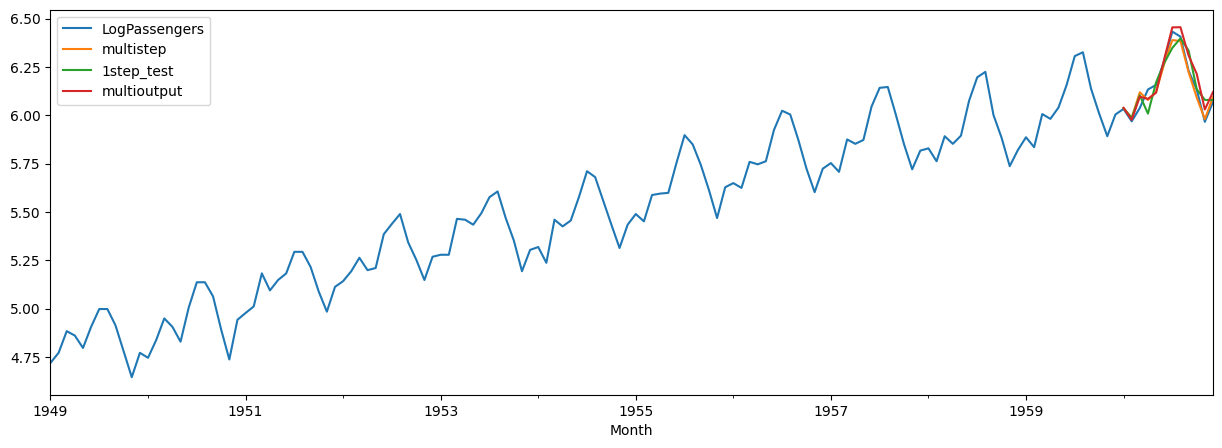

In [95]:
# plot all forecasts
cols = ['LogPassengers', 'multistep', '1step_test', 'multioutput']
df[cols].plot(figsize=(15, 5));

In [96]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogPassengers']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.0049056624349090834
multi-output MAPE: 0.006969759999197245
